# Forecasting

In this notebook we train our models to perform and evaluate bixi usage forecasts.

Model tuning and performance assesment is done via a cross-validation procedue using a seasonal time-series split on the training data. After the tuning is complete, we evaluate final model performance by performing a forecast on the test data.

Required imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Validation
from lib import validation as val

# Imports required for particular models are done in their respective sections

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

### Load the Data

Load the Mont-Royal trip history data.

In [2]:
station_bike_demand = pd.read_csv('data/mr_bike_demand.csv', index_col='start_date', parse_dates=['start_date']).asfreq('D')
display(station_bike_demand.head())

,trip_count
start_date,
2014-04-15,31
2014-04-16,67
2014-04-17,140
2014-04-18,108
2014-04-19,128


### Split the Data

Split the data into training and test sets.
* Training set: from 2014 to 2018 (inclusive)
* Test set: 2019

Since the main low-frequency data periodicity is yearly, it makes sense to do a yearly split. This split gives approximately a 5 to 1 training to test split ratio (about 83:17).

**Notes**: 
* 2020 was excluded due to overall trend dip because of the pandemic, as can be seen in the visualization notebook.
* 2019 is missing the data for November so using it as test data will lead to large errors for November. We might want to exlude November from the test error calculations,

In [3]:
# Split station data into training and test set
demand_train = station_bike_demand['2014':'2018']
demand_test  = station_bike_demand['2019':'2019']

# Add zeros for 2014 before April to have consistent period windows
df = pd.DataFrame(index=pd.date_range(start='2014-01-01', end='2014-04-14', freq='D'), columns=['trip_count'])
df['trip_count'] = 0
demand_train = pd.concat([df, demand_train])

# Exclude November data from the test set
demand_test  = demand_test[:'2019-10-31']

**Note**: there is one extra day in 2016 (leap year). Removing it seems to break the proper data frequency and letting it be shifts all periods by one. For now we leave it as it is, since a one day shift during a 0 usage period should not make a significant impact.

In [4]:
# Define validation and test parameters

# Configure the seasonal period to be yearly
seasonal_period = 365
# Configure test forecasting horizon to exclude November
test_fh = np.arange(1, 304+1)

# Dummy Baselines

## Seasonal Naive Baseline 

We will use Seasonal Naive model from the **sktime** library as our dummy baseline in two configurations:
* *last* - use the last year data as the prediction for the next.
* *mean* - use the mean data of all previous years as the prediction for the next.

Imports:

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

### Cross Validation

Use time-series split to perform cross-validation.

In [ ]:
# Perform CV using the last strategy
forecaster = NaiveForecaster(strategy="last", sp = seasonal_period)
results = val.evaluate_cv(forecaster, demand_train, seasonal_period)

# Display CV results
display(results)
display(results.mean())

# Plot CV forecasts
val.plot_cv_results(results, demand_train)

In [ ]:
# Perform CV using the mean strategy
forecaster = NaiveForecaster(strategy="mean", sp = seasonal_period)
results = val.evaluate_cv(forecaster, demand_train, seasonal_period)

# Display CV results
display(results)
display(results.mean())

# Plot CV forecasts
val.plot_cv_results(results, demand_train)

### Test Validation

In [ ]:
# Forecast using the seasonal naive random walk forecast
forecaster = NaiveForecaster(strategy="last", sp = seasonal_period) 
forecaster.fit(demand_train)

# Evaluate the forecast
val.eval_forecast(forecaster, test_fh, demand_test)

In [ ]:
# Forecast using the seasonal naive mean forecast
forecaster = NaiveForecaster(strategy="mean", sp = seasonal_period) 
forecaster.fit(demand_train)

# Evaluate and plot the forecast
val.eval_forecast(forecaster, test_fh, demand_test)

# Facebook Prophet

Basic Facebook Prophet baseline.

**Note**: needs some tuning to perform well.

Required imports:

In [ ]:
from sktime.forecasting.fbprophet import Prophet

In [ ]:
# Convert the training DF to a Series
y = demand_train['trip_count']

# Configure the model
forecaster = Prophet(
    seasonality_mode='additive',
    n_changepoints=25, # default
    add_country_holidays={'country_name': 'Canada'},
    daily_seasonality=False,
    yearly_seasonality=True)

### Cross Validation

In [ ]:
# Perform CV using the mean strategy
results = evaluate_cv(forecaster, y, seasonal_period)

# Display CV results
display(results)
display(results.mean())

# Plot CV forecasts
val.plot_cv_results(results, demand_train)

### Test Validation

In [ ]:
# Configure the model
forecaster = Prophet(
    seasonality_mode='additive',
    n_changepoints=25, # default
    add_country_holidays={'country_name': 'Canada'},
    daily_seasonality=False,
    yearly_seasonality=True)

# Train the model
forecaster.fit(y)

In [ ]:
# Evaluate and plot the forecast
val.eval_forecast(forecaster, test_fh, demand_test)

# Model 1

Add your models here.

In [8]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.utils.plotting import plot_series

/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:68: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:71: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


MeanAbsolutePercentageError: 1.392372504860266
MeanSquaredError: 135.34350819806224


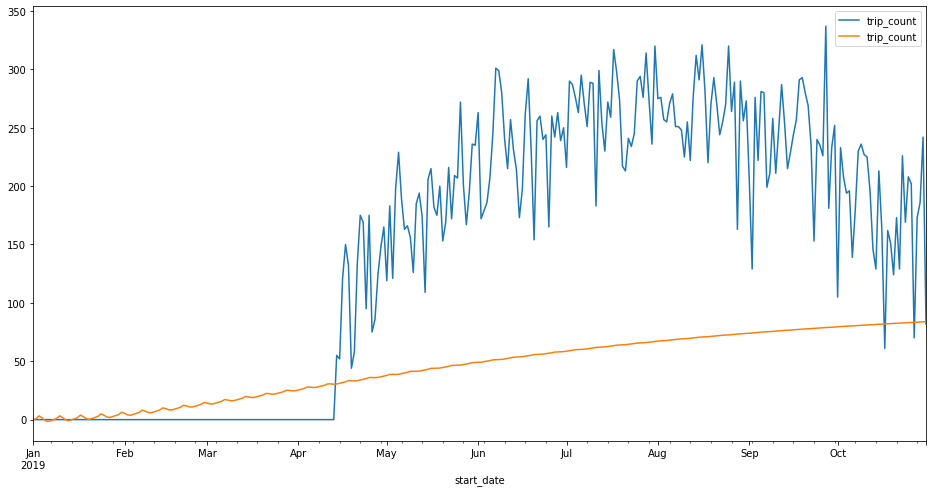

In [9]:
fh = np.arange(1, len(demand_test)+1)
forecaster = AutoARIMA(sp=7, suppress_warnings=True)
forecaster.fit(demand_train)
eval_forecast(forecaster, fh, demand_test)

/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:68: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:71: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.fre

,MeanAbsolutePercentageError,MeanSquaredError,y_train,y_val,y_pred
0,2.000000,220.518832,trip_count 2014-01-01 0 ...,trip_count 2015-01-01 0 ...,trip_count 2015-01-01 -1.586181 ...
1,2.000000,211.021816,trip_count 2014-01-01 0 ...,trip_count 2016-01-01 0 ...,trip_count 2016-01-01 0.670226 ...
2,2.000000,168.257223,trip_count 2014-01-01 0 ...,trip_count 2016-12-31 0 ...,trip_count 2016-12-31 -6.023223 ...
3,1.384428,124.305431,trip_count 2014-01-01 0 ...,trip_count 2017-12-31 0 ...,trip_count 2017-12-31 -3.708119 ...


/var/folders/fl/v8dr36vx66jg839921j_2tn40000gp/T/ipykernel_42931/3011449458.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(results.mean())


MeanAbsolutePercentageError      1.846107
MeanSquaredError               181.025825
dtype: float64

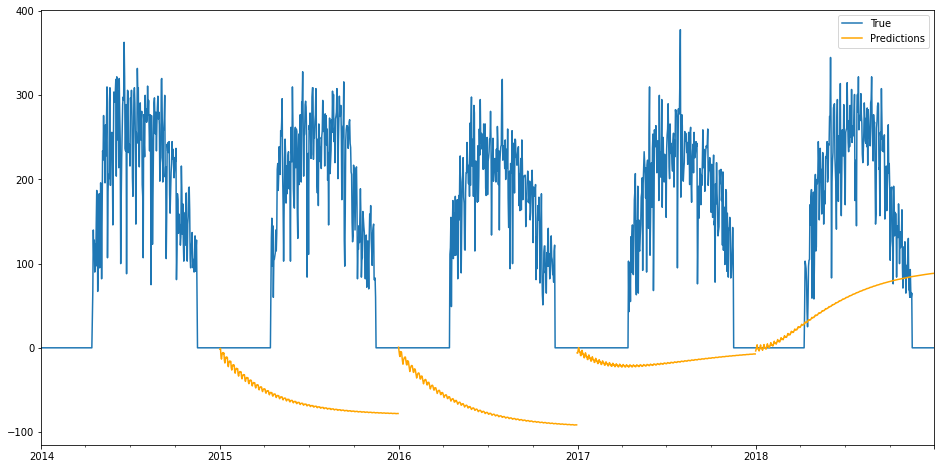

In [10]:
# Perform CV using the mean strategy
forecaster = AutoARIMA(sp=7, suppress_warnings=True)
results = val.evaluate_cv(forecaster, demand_train, seasonal_period)

# Display CV results
display(results)
display(results.mean())

# Plot CV forecasts
val.plot_cv_results(results, demand_train)

/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:68: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:71: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


MeanAbsolutePercentageError: 2.0
MeanSquaredError: 194.60749625922276


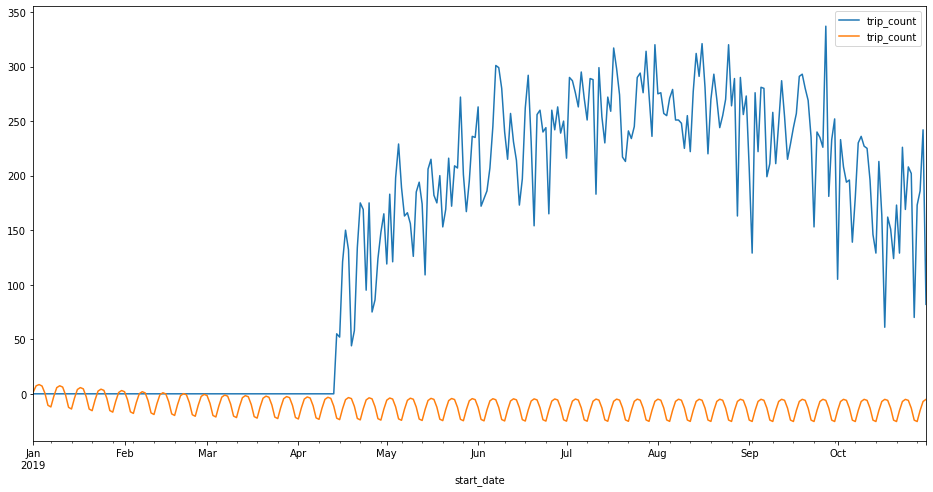

In [12]:
from sktime.forecasting.tbats import TBATS
fh = np.arange(1, len(demand_test)+1)
forecaster = TBATS(sp=7, use_trend=True, use_box_cox=False)
forecaster.fit(demand_train)
eval_forecast(forecaster, fh, demand_test)

/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if x.freqstr is None:
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:68: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  elif "-" in x.freqstr:
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:71: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/usr/local/lib/python3.9/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.fre

,MeanAbsolutePercentageError,MeanSquaredError,y_train,y_val,y_pred
0,2.000000,506.421726,trip_count 2014-01-01 0 ...,trip_count 2015-01-01 0 ...,trip_count 2015-01-01 8.297358 ...
1,1.966259,151.846559,trip_count 2014-01-01 0 ...,trip_count 2016-01-01 0 ...,trip_count 2016-01-01 1.492124 ...
2,2.000000,180.184289,trip_count 2014-01-01 0 ...,trip_count 2016-12-31 0 ...,trip_count 2016-12-31 -9.265519 ...
3,2.000000,302.541429,trip_count 2014-01-01 0 ...,trip_count 2017-12-31 0 ...,trip_count 2017-12-31 -14.104477 ...


/var/folders/fl/v8dr36vx66jg839921j_2tn40000gp/T/ipykernel_42931/1475577921.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(results.mean())


MeanAbsolutePercentageError      1.991565
MeanSquaredError               285.248501
dtype: float64

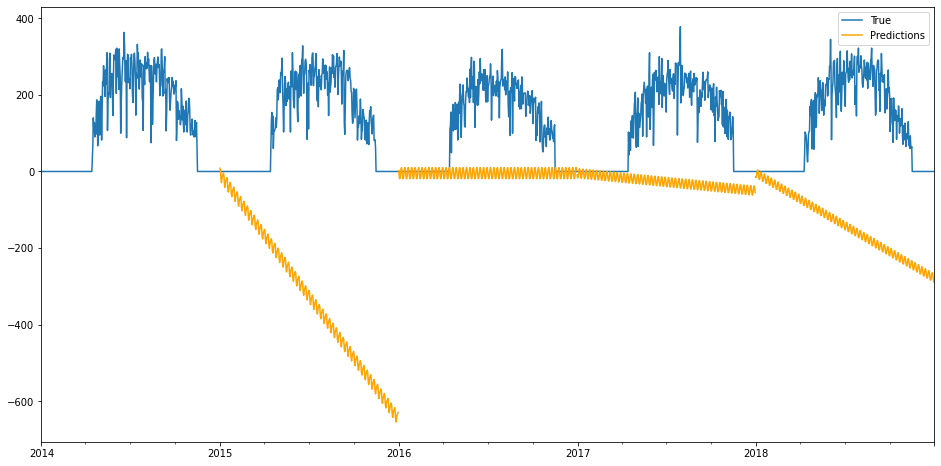

In [13]:
# Perform CV using the mean strategy
forecaster = TBATS(sp=7, use_trend=True, use_box_cox=False)
results = val.evaluate_cv(forecaster, demand_train, seasonal_period)

# Display CV results
display(results)
display(results.mean())

# Plot CV forecasts
val.plot_cv_results(results, demand_train)